# 모델링에 사용한 library들의 버전
NumPy version: 1.24.0

Pandas version: 2.1.0

Matplotlib version: 3.7.2

Seaborn version: 0.12.2

CatBoost version: 1.2.1.1.16484

Scikit-Learn version: 1.3.0

SciPy version: 1.11.2

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier


from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from scipy.stats import ks_2samp

from itertools import combinations

In [2]:
import scipy
import sklearn

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("CatBoost version:", catboost.__version__)
print("Scikit-Learn version:", sklearn.__version__)


print("SciPy version:", scipy.__version__)



NumPy version: 1.24.0
Pandas version: 2.1.0
Matplotlib version: 3.7.2
Seaborn version: 0.12.2
CatBoost version: 1.2.1.1.16484
Scikit-Learn version: 1.3.0
SciPy version: 1.11.2


# data폴더에 있는 train.csv, test.csv파일 불러오기

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# test에 없는 컬럼들의 분포를 확인하고, null값이 존재하는 컬럼은 그 비율이 높기 때문에 삭제하기로 결정

In [4]:
nan_count_by_column = train.isnull().sum()

# nan값이 하나라도 있는 컬럼과 개수를 출력
columns_with_nan = nan_count_by_column[nan_count_by_column > 0]
print("Columns with NaN values and their counts:")
print(columns_with_nan)

Columns with NaN values and their counts:
CD                 1394
FH2O              10205
FNOX              10205
FOPTIMETHGLY      10205
FOXID             10205
FSO4              10205
FTBN              10205
FUEL              10205
K                  2299
SOOTPERCENTAGE    10205
U100              11779
U75               11779
U50               11779
U25               11779
U20               11779
U14               11977
U6                11977
U4                11977
V100              10371
dtype: int64


In [5]:
train_1 = train.dropna(axis=1)
column_names = train_1.columns
print(column_names)

train_1 = train_1.drop(['ID'], axis=1)

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P',
       'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'ZN',
       'Y_LABEL'],
      dtype='object')


# 원소 컬럼들 중에 정상과 비정상의 분포가 유의미한 차이가 없는 컬럼 삭제

In [6]:
# K-S 검정 결과를 저장할 딕셔너리
ks_test_results = {}

element_columns = ['AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CO', 'CR', 'CU', 'FE','LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'ZN']

#  "Y_LABEL"이 1인 행만 선택하여 train_2_1 데이터프레임 생성
train_2_1 = train_1[train_1['Y_LABEL'] == 1]

# "Y_LABEL"이 0인 행만 선택하여 train_2_0 데이터프레임 생성
train_2_0 = train_1[train_1['Y_LABEL'] == 0]

# element_columns 리스트에 있는 모든 컬럼 쌍에 대해 K-S 검정 수행
for i in range(len(element_columns)):
    column_1 = train_2_0[element_columns[i]]
    column_2 = train_2_1[element_columns[i]]
    
    # K-S 검정 수행
    ks_statistic, p_value = ks_2samp(column_1, column_2)
    
    # 결과를 딕셔너리에 저장
    test_name = f"{element_columns[i]}"
    ks_test_results[test_name] = (ks_statistic, p_value)

# K-S 검정 결과 출력 및 유의미하지 않는 컬럼 출력
significant_differences = []
for test_name, (ks_statistic, p_value) in ks_test_results.items():
    
    # 유의수준 0.05에서 유의미한 차이 확인
    alpha = 0.05
    if p_value >= alpha:
        significant_differences.append(test_name)
        
# 유의미하지 않는 컬럼들 출력
if significant_differences:
    print("유의미하지 않는 컬럼:")
    print(significant_differences)
else:
    print("유의미하지 않는 컬럼이 없습니다.")

유의미하지 않는 컬럼:
['AG', 'B', 'BA', 'BE']


In [7]:
train_1 = train_1.drop(['AG', 'B', 'BA', 'BE'], axis=1)

# 컬럼별로 outlier의 분포를 확인후 비정상 데이터에서 outlier가 많은 경우, 최소 이상치를 구해 그 값보다 클 경우 'yes' 아니면 'no'로 구성된 파생변수 생성

In [8]:
# 각 컬럼별로 이상치 판별 임계값을 계산하는 함수
def find_outlier_thresholds(data, threshold=3):
    thresholds = {}
    min_outliers = {}  # 각 컬럼별 최소 이상치 값을 저장하기 위한 딕셔너리
    
    for column in data.select_dtypes(include=[np.number]).columns:
        # 각 컬럼의 Z-Score 계산
        z_scores = (data[column] - data[column].mean()) / data[column].std()
        
        # Z-Score가 임계값보다 큰 데이터를 이상치로 판단
        outliers = data[np.abs(z_scores) > threshold]
        
        # 이상치 판별 임계값 저장
        thresholds[column] = {
            'threshold': threshold,
            'outliers_count': len(outliers),
            'outliers_indices': list(outliers.index)
        }
        
        # 최소 이상치 값 찾기
        if len(outliers) > 0:
            min_outliers[column] = outliers[column].min()
    
    return thresholds, min_outliers

# 예시 데이터 프레임 생성 (스트링 데이터를 가진 'C' 컬럼 추가)

# 이상치 판별 임계값 계산 (임계값은 3으로 설정)
outlier_thresholds, min_outliers = find_outlier_thresholds(train_1, threshold=3)

# Y_LABEL 값에 따라 이상치 개수와 각 컬럼별 최소 이상치 값을 구분하여 출력
for column, threshold_info in outlier_thresholds.items():
    print(f"Column: {column}")
    print(f"Threshold: {threshold_info['threshold']}")
    
    # Y_LABEL이 1인 샘플 중 이상치 개수
    outliers_1 = len([idx for idx in threshold_info['outliers_indices'] if train_1.loc[idx, 'Y_LABEL'] == 1])
    print(f"Number of Outliers (Y_LABEL=1): {outliers_1}")

    # Y_LABEL이 0인 샘플 중 이상치 개수
    outliers_0 = len([idx for idx in threshold_info['outliers_indices'] if train_1.loc[idx, 'Y_LABEL'] == 0])
    print(f"Number of Outliers (Y_LABEL=0): {outliers_0}")
    
    # 최소 이상치 값 출력
    if column in min_outliers:
        print(f"Min Outlier Value: {min_outliers[column]}")

    print()


Column: ANONYMOUS_1
Threshold: 3
Number of Outliers (Y_LABEL=1): 13
Number of Outliers (Y_LABEL=0): 37
Min Outlier Value: -0.896302960289793

Column: YEAR
Threshold: 3
Number of Outliers (Y_LABEL=1): 0
Number of Outliers (Y_LABEL=0): 0

Column: SAMPLE_TRANSFER_DAY
Threshold: 3
Number of Outliers (Y_LABEL=1): 43
Number of Outliers (Y_LABEL=0): 158
Min Outlier Value: 43

Column: ANONYMOUS_2
Threshold: 3
Number of Outliers (Y_LABEL=1): 31
Number of Outliers (Y_LABEL=0): 104
Min Outlier Value: -0.6029629629629629

Column: AL
Threshold: 3
Number of Outliers (Y_LABEL=1): 52
Number of Outliers (Y_LABEL=0): 84
Min Outlier Value: 275

Column: CA
Threshold: 3
Number of Outliers (Y_LABEL=1): 0
Number of Outliers (Y_LABEL=0): 1
Min Outlier Value: 6609

Column: CO
Threshold: 3
Number of Outliers (Y_LABEL=1): 146
Number of Outliers (Y_LABEL=0): 151
Min Outlier Value: 1

Column: CR
Threshold: 3
Number of Outliers (Y_LABEL=1): 32
Number of Outliers (Y_LABEL=0): 0
Min Outlier Value: 93

Column: CU
Thre

In [9]:
# 'FE_outlier' 컬럼 생성 및 설정
train_1['FE_outlier'] = np.where(train_1['FE'] > 1778, 'yes', 'no')

# 'PQINDEX_outlier' 컬럼 생성 및 설정
train_1['PQINDEX_outlier'] = np.where(train_1['PQINDEX'] > 5032, 'yes', 'no')

# 'SI_outlier' 컬럼 생성 및 설정
train_1['SI_outlier'] = np.where(train_1['SI'] > 627, 1, 'no')


# 'FE_outlier' 컬럼 생성 및 설정
test['FE_outlier'] = np.where(test['FE'] > 1778, 'yes', 'no')

# 'PQINDEX_outlier' 컬럼 생성 및 설정
test['PQINDEX_outlier'] = np.where(test['PQINDEX'] > 5032, 'yes', 'no')

# 'SI_outlier' 컬럼 생성 및 설정
# test['SI_outlier'] = np.where(test['SI'] > 627, 1, 0)


# 원소 컬럼이 아닌, COMPONENT_ARBITRARY, SAMPLE_TRNAFER_DAY, YEAR의 분포 확인

In [10]:
different_columns = ['COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY']

# different_columns 리스트에 있는 컬럼들의 고유한 값들의 비율 계산
unique_ratios_0 = {}
unique_ratios_1 = {}

for column in different_columns:
    unique_value_counts = train_2_0[column].value_counts()  # 각 고유한 값들의 개수
    total_values = len(train_2_0)  # 전체 값 개수
    ratio = unique_value_counts / total_values  # 비율 계산
    unique_ratios_0[column] = ratio
    
    
# 결과 출력
for column, ratios in unique_ratios_0.items():
    print(f"정상의 컬럼 '{column}'의 고유한 값들의 비율:")
    print(ratios)
    print()

for column in different_columns:
    unique_value_counts = train_2_1[column].value_counts()  # 각 고유한 값들의 개수
    total_values = len(train_2_1)  # 전체 값 개수
    ratio = unique_value_counts / total_values  # 비율 계산
    unique_ratios_1[column] = ratio

for column, ratios in unique_ratios_1.items():
    print(f"비정상의 컬럼 '{column}'의 고유한 값들의 비율:")
    print(ratios)
    print()


different_columns = ['YEAR']

unique_ratios_5 = {}
unique_ratios_6 = {}

for column in different_columns:
    unique_value_counts = train_2_0[column].value_counts()  # 각 고유한 값들의 개수
    total_values = len(train_2_0)  # 전체 값 개수
    ratio = unique_value_counts / total_values  # 비율 계산
    unique_ratios_5[column] = ratio

for column, ratios in unique_ratios_5.items():
    print(f"정상의 컬럼 '{column}'의 고유한 값들의 비율:")
    print(ratios)
    print()

for column in different_columns:
    unique_value_counts = train_2_1[column].value_counts()  # 각 고유한 값들의 개수
    total_values = len(train_2_1)  # 전체 값 개수
    ratio = unique_value_counts / total_values  # 비율 계산
    unique_ratios_6[column] = ratio

for column, ratios in unique_ratios_6.items():
    print(f"비정상의 컬럼 '{column}'의 고유한 값들의 비율:")
    print(ratios)
    print()

정상의 컬럼 'COMPONENT_ARBITRARY'의 고유한 값들의 비율:
COMPONENT_ARBITRARY
COMPONENT3    0.443140
COMPONENT1    0.316141
COMPONENT2    0.172974
COMPONENT4    0.067745
Name: count, dtype: float64

정상의 컬럼 'SAMPLE_TRANSFER_DAY'의 고유한 값들의 비율:
SAMPLE_TRANSFER_DAY
2      0.130250
5      0.120856
6      0.118508
4      0.113901
3      0.104146
         ...   
52     0.000090
153    0.000090
111    0.000090
66     0.000090
161    0.000090
Name: count, Length: 103, dtype: float64

비정상의 컬럼 'COMPONENT_ARBITRARY'의 고유한 값들의 비율:
COMPONENT_ARBITRARY
COMPONENT3    0.708995
COMPONENT2    0.132606
COMPONENT1    0.128968
COMPONENT4    0.029431
Name: count, dtype: float64

비정상의 컬럼 'SAMPLE_TRANSFER_DAY'의 고유한 값들의 비율:
SAMPLE_TRANSFER_DAY
6      0.131944
2      0.123347
5      0.120040
4      0.115741
3      0.106481
         ...   
65     0.000331
48     0.000331
38     0.000331
108    0.000331
57     0.000331
Name: count, Length: 69, dtype: float64

정상의 컬럼 'YEAR'의 고유한 값들의 비율:
YEAR
2014    0.102339
2008    0.095926
2013   

In [11]:
train_1 = train_1.drop(['YEAR', 'SAMPLE_TRANSFER_DAY'], axis=1)

# test에 없는 컬럼들 중 0의 비율이 높은데, 정상과 비정상의 차이가 없는 컬럼 삭제

In [12]:
zero_ratio_0 = (train_2_0 == 0).mean()
selected_columns_0 = zero_ratio_0[zero_ratio_0 >= 0.4]
# display(zero_ratio_0)
display(selected_columns_0)


zero_ratio_1 = (train_2_1 == 0).mean()
selected_columns_1 = zero_ratio_1[zero_ratio_1 >= 0.4]
# display(zero_ratio_1)
display(selected_columns_1)

AG         0.978322
BA         0.769759
BE         0.996748
CO         0.986361
CR         0.496342
H2O        0.989883
LI         0.929184
MN         0.576371
MO         0.463553
NI         0.848252
PB         0.586397
SB         0.798573
SN         0.717099
TI         0.964502
V          0.982748
Y_LABEL    1.000000
dtype: float64

AG     0.968915
BA     0.746693
BE     0.995040
CO     0.951720
H2O    0.907407
LI     0.860119
MO     0.455026
NI     0.540013
PB     0.602844
SB     0.756283
SN     0.677249
TI     0.702381
V      0.931217
dtype: float64

In [13]:
train_1 = train_1.drop(['LI', 'PB', 'SB', 'SN'], axis=1)

# test에 있는 컬럼들 중 0의 비율이 높은 컬럼들을 카테고리 변수로 전환하고, 파생변수 생성
# 이때 원소들은 2개, 3개, 4개까지 조합을 하고, 비정상과 정상의 비율이 차이가 나는 것들만 파생변수로 지정한다. 
# 조합별로 각 컬럼이 다 0일 경우 no, 1일 경우 yes로 값을 할당한다.

In [14]:
change_columns = ['CO', 'CR',  'MN', 'NI', 'TI', 'V', 'H2O']
for column in change_columns:
    train_1[column] = train_1[column].apply(lambda x: 'yes' if x != 0 else 'no')
    test[column] = test[column].apply(lambda x: 'yes' if x != 0 else 'no')

In [15]:
# 'CO', 'CR', 'MN', 'NI', 'TI', 'V', 'H2O' 컬럼 선택
selected_columns = train_1[change_columns]
selected_columns_2 = test[change_columns]


# 선택한 컬럼들의 이름
column_names = selected_columns.columns

# 두 컬럼씩 조합을 생성하고 결과를 저장할 딕셔너리
result_dict = {}

# 두 컬럼씩 조합을 반복하면서 두 컬럼이 모두 'no'인 비율 계산
for combo in combinations(column_names, 2):
    col1, col2 = combo
    both_no_rows = ((selected_columns[col1] == 'no') & (selected_columns[col2] == 'no'))
    both_no_ratio = both_no_rows.mean()
    
    # 비율이 0.8 이상인 경우만 저장
    if both_no_ratio >= 0.8:
        result_dict[f"{col1} - {col2}"] = both_no_ratio

# 결과 출력
for combo, ratio in result_dict.items():
    print(f"Combo: {combo}, Ratio: {ratio:.4f}")

# 각 데이터에 대해 조합의 'no' 여부 계산
for combo in result_dict.keys():
    col1, col2 = combo.split(" - ")
    train_1[combo] = np.where((selected_columns[col1] == 'no') & (selected_columns[col2] == 'no'), 'no', 'yes')
    test[combo] = np.where((selected_columns_2[col1] == 'no') & (selected_columns_2[col2] == 'no'), 'no', 'yes')
    


Combo: CO - TI, Ratio: 0.8966
Combo: CO - V, Ratio: 0.9595
Combo: CO - H2O, Ratio: 0.9543
Combo: TI - V, Ratio: 0.8979
Combo: TI - H2O, Ratio: 0.8944
Combo: V - H2O, Ratio: 0.9491


In [16]:
# 선택할 컬럼들 정의
change_columns = ['CO', 'CR', 'MN', 'NI', 'TI', 'V', 'H2O']
selected_columns = train_1[change_columns]
selected_columns_2 = test[change_columns]

# 선택한 컬럼들의 이름
column_names = selected_columns.columns

# 조합의 크기 설정 (3개의 컬럼 조합)
combo_size = 3

# 두 컬럼씩 조합을 생성하고 결과를 저장할 딕셔너리
result_dict = {}

# 컬럼 조합 생성 및 계산
for combo in combinations(column_names, combo_size):
    combo_list = list(combo)
    all_no_rows = np.all(selected_columns[combo_list] == 'no', axis=1)
    all_no_ratio = all_no_rows.mean()
    
    # 비율이 0.8 이상인 경우만 저장
    if all_no_ratio >= 0.8:
        result_dict[" - ".join(combo_list)] = all_no_ratio

# 결과 출력
for combo, ratio in result_dict.items():
    print(f"Combo: {combo}, Ratio: {ratio:.4f}")

# 각 데이터에 대해 조합의 'no' 여부 계산 및 추가
for combo in result_dict.keys():
    combo_list = combo.split(" - ")
    all_no_rows_train = np.all(selected_columns[combo_list] == 'no', axis=1)
    all_no_rows_test = np.all(selected_columns_2[combo_list] == 'no', axis=1)
    
    train_1[combo] = np.where(all_no_rows_train, 'no', 'yes')
    test[combo] = np.where(all_no_rows_test, 'no', 'yes')


Combo: CO - TI - V, Ratio: 0.8885
Combo: CO - TI - H2O, Ratio: 0.8831
Combo: CO - V - H2O, Ratio: 0.9377
Combo: TI - V - H2O, Ratio: 0.8841


In [17]:
# 선택할 컬럼들 정의
change_columns = ['CO', 'CR', 'MN', 'NI', 'TI', 'V', 'H2O']
selected_columns = train_1[change_columns]
selected_columns_2 = test[change_columns]

# 선택한 컬럼들의 이름
column_names = selected_columns.columns

# 조합의 크기 설정 (4개의 컬럼 조합)
combo_size = 4

# 두 컬럼씩 조합을 생성하고 결과를 저장할 딕셔너리
result_dict = {}

# 컬럼 조합 생성 및 계산
for combo in combinations(column_names, combo_size):
    combo_list = list(combo)
    all_no_rows = np.all(selected_columns[combo_list] == 'no', axis=1)
    all_no_ratio = all_no_rows.mean()
    
    # 비율이 0.8 이상인 경우만 저장
    if all_no_ratio >= 0.8:
        result_dict[" - ".join(combo_list)] = all_no_ratio

# 결과 출력
for combo, ratio in result_dict.items():
    print(f"Combo: {combo}, Ratio: {ratio:.4f}")

# 각 데이터에 대해 조합의 'no' 여부 계산 및 추가
for combo in result_dict.keys():
    combo_list = combo.split(" - ")
    all_no_rows_train = np.all(selected_columns[combo_list] == 'no', axis=1)
    all_no_rows_test = np.all(selected_columns_2[combo_list] == 'no', axis=1)
    
    train_1[combo] = np.where(all_no_rows_train, 'no', 'yes')
    test[combo] = np.where(all_no_rows_test, 'no', 'yes')


Combo: CO - TI - V - H2O, Ratio: 0.8751


In [18]:
combo_columns = ['CO - TI', 'CO - V', 'CO - H2O', 'TI - V', 'TI - H2O', 'V - H2O','CO - TI - V', 'CO - TI - H2O', 'CO - V - H2O', 'TI - V - H2O', 'CO - TI - V - H2O']

#  "Y_LABEL"이 1인 행만 선택하여 train_2_1 데이터프레임 생성
train_2_1 = train_1[train_1['Y_LABEL'] == 1]

# "Y_LABEL"이 0인 행만 선택하여 train_2_0 데이터프레임 생성
train_2_0 = train_1[train_1['Y_LABEL'] == 0]


# 'yes'와 'no' 비율을 저장할 딕셔너리
result_dict_0 = {}
result_dict_1 = {}

for col in combo_columns:
    # train_2_0에서 각 컬럼의 'yes'와 'no' 비율 계산
    no_ratio_0 = (train_2_0[col] == 'no').mean()
    yes_ratio_0 = (train_2_0[col] == 'yes').mean()
    result_dict_0[col] = (no_ratio_0, yes_ratio_0)
    
    # train_2_1에서 각 컬럼의 'yes'와 'no' 비율 계산
    no_ratio_1 = (train_2_1[col] == 'no').mean()
    yes_ratio_1 = (train_2_1[col] == 'yes').mean()
    result_dict_1[col] = (no_ratio_1, yes_ratio_1)

# 결과 출력
for col, (no_ratio_0, yes_ratio_0) in result_dict_0.items():
    no_ratio_1, yes_ratio_1 = result_dict_1[col]
    print(f"Column: {col}")
    print(f"Train_2_0 - No Ratio: {no_ratio_0:.4f}, Yes Ratio: {yes_ratio_0:.4f}")
    print(f"Train_2_1 - No Ratio: {no_ratio_1:.4f}, Yes Ratio: {yes_ratio_1:.4f}")
    print()



Column: CO - TI
Train_2_0 - No Ratio: 0.9538, Yes Ratio: 0.0462
Train_2_1 - No Ratio: 0.6872, Yes Ratio: 0.3128

Column: CO - V
Train_2_0 - No Ratio: 0.9729, Yes Ratio: 0.0271
Train_2_1 - No Ratio: 0.9104, Yes Ratio: 0.0896

Column: CO - H2O
Train_2_0 - No Ratio: 0.9769, Yes Ratio: 0.0231
Train_2_1 - No Ratio: 0.8717, Yes Ratio: 0.1283

Column: TI - V
Train_2_0 - No Ratio: 0.9538, Yes Ratio: 0.0462
Train_2_1 - No Ratio: 0.6931, Yes Ratio: 0.3069

Column: TI - H2O
Train_2_0 - No Ratio: 0.9556, Yes Ratio: 0.0444
Train_2_1 - No Ratio: 0.6703, Yes Ratio: 0.3297

Column: V - H2O
Train_2_0 - No Ratio: 0.9731, Yes Ratio: 0.0269
Train_2_1 - No Ratio: 0.8611, Yes Ratio: 0.1389

Column: CO - TI - V
Train_2_0 - No Ratio: 0.9451, Yes Ratio: 0.0549
Train_2_1 - No Ratio: 0.6812, Yes Ratio: 0.3188

Column: CO - TI - H2O
Train_2_0 - No Ratio: 0.9453, Yes Ratio: 0.0547
Train_2_1 - No Ratio: 0.6554, Yes Ratio: 0.3446

Column: CO - V - H2O
Train_2_0 - No Ratio: 0.9637, Yes Ratio: 0.0363
Train_2_1 - No Ra

# label 데이터를 생성하고, 파생변수 중 비율의 차이가 없는 것들을 삭제함.
# test 데이터 전처리

In [19]:
# 'Y_LABEL'을 train_y로 복사
train_y = train_1['Y_LABEL']

# 라벨을 제외한 나머지 열을 train_X로 복사
train_X = train_1.drop(['Y_LABEL', 'CO - V', 'CO - H2O', 'V - H2O', 'CO - V - H2O'], axis=1)

In [20]:
test = test.drop(['ID'], axis=1)
test = test.drop(['AG'], axis=1)
test = test.drop(['YEAR'], axis=1)
test = test.drop(['CO - V', 'CO - H2O', 'V - H2O', 'CO - V - H2O'], axis=1)

# 1차 모델인 분류모델 생성하고 이 분류모델의 확률예측 값을 2차 모델의 y값으로 지정함

In [21]:
display(train_X.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  object 
 1   ANONYMOUS_1          14095 non-null  float64
 2   ANONYMOUS_2          14095 non-null  float64
 3   AL                   14095 non-null  int64  
 4   CA                   14095 non-null  int64  
 5   CO                   14095 non-null  object 
 6   CR                   14095 non-null  object 
 7   CU                   14095 non-null  int64  
 8   FE                   14095 non-null  int64  
 9   H2O                  14095 non-null  object 
 10  MG                   14095 non-null  int64  
 11  MN                   14095 non-null  object 
 12  MO                   14095 non-null  int64  
 13  NA                   14095 non-null  int64  
 14  NI                   14095 non-null  object 
 15  P                    14095 non-null 

None

None

In [22]:
# 학습 데이터를 특성 데이터와 라벨 데이터로 분리
X = train_X.values  # 특성 데이터
y = train_y.values  # 라벨 데이터

# Stratified K-Fold 교차 검증 설정
n_splits = 5  # 원하는 Fold 수
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# CatBoost Classifier 모델
cat_features = [0, 5, 6, 9, 11, 14, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

# 최적의 하이퍼파라미터 설정
best_params = {'depth': 10, 'iterations': 1500, 'learning_rate': 0.01}

# 교차 검증 수행 및 평가 지표 저장
macro_f1_scores = []
probabilities_list = []
best_f1_score = 0

for train_index, valid_index in skf.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    # CatBoost 모델 생성 및 학습
    model = CatBoostClassifier(loss_function='Logloss', cat_features=cat_features, eval_metric='F1', 
                               random_seed=42, verbose=500, **best_params)
    
    model.fit(X_train, y_train)

    # 검증 데이터에 대한 예측 및 평가 (Macro F1 Score)
    valid_predictions = model.predict(X_valid)
    macro_f1 = f1_score(y_valid, valid_predictions, average='macro')
    macro_f1_scores.append(macro_f1)

    if macro_f1 > best_f1_score:
        best_f1_score = macro_f1
        best_classification_model = model

# Macro F1 Score 출력
print("Macro F1 Scores:", macro_f1_scores)

0:	learn: 0.6303381	total: 91.1ms	remaining: 2m 16s
500:	learn: 0.7805789	total: 14.6s	remaining: 29.1s
1000:	learn: 0.8585812	total: 28.9s	remaining: 14.4s
1499:	learn: 0.9221557	total: 43.5s	remaining: 0us
0:	learn: 0.6200594	total: 27.8ms	remaining: 41.7s
500:	learn: 0.7752625	total: 14.2s	remaining: 28.2s
1000:	learn: 0.8590298	total: 28.4s	remaining: 14.2s
1499:	learn: 0.9178658	total: 43.6s	remaining: 0us
0:	learn: 0.6273195	total: 33ms	remaining: 49.5s
500:	learn: 0.7763066	total: 14.3s	remaining: 28.5s
1000:	learn: 0.8676603	total: 28.3s	remaining: 14.1s
1499:	learn: 0.9213086	total: 42.7s	remaining: 0us
0:	learn: 0.6232600	total: 27.4ms	remaining: 41.1s
500:	learn: 0.7823640	total: 13.6s	remaining: 27.2s
1000:	learn: 0.8653714	total: 27.9s	remaining: 13.9s
1499:	learn: 0.9247788	total: 42.6s	remaining: 0us
0:	learn: 0.6210839	total: 30.1ms	remaining: 45.1s
500:	learn: 0.7857641	total: 14.3s	remaining: 28.6s
1000:	learn: 0.8710407	total: 28.7s	remaining: 14.3s
1499:	learn: 0.92

In [28]:
best_classification_model.save_model('best_catboost_classification_model')

In [24]:
train_X['predicted_probability'] = best_classification_model.predict_proba(train_X.values)[:, 1]

# 2차 모델의 입력 데이터는 test데이터에 존재하는 컬럼들로만 학습시켜야함. 그래야 test 데이터로 예측 결과를 확인할 수 있기 때문임.
# 2차 모델은 분류 모델이 아니라 1차 모델에서 생성한 확률값을 예측하는 회귀 모델임.

In [25]:
teacher_except_columns = ['AL', 'CA', 'MG', 'NA', 'P', 'S', 'SI', 'SI_outlier']
train_t_X = train_X.drop(teacher_except_columns, axis=1)
train_t_y = train_t_X['predicted_probability']
train_t_X = train_t_X.drop(['predicted_probability'], axis=1)

In [26]:
train_t_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  object 
 1   ANONYMOUS_1          14095 non-null  float64
 2   ANONYMOUS_2          14095 non-null  float64
 3   CO                   14095 non-null  object 
 4   CR                   14095 non-null  object 
 5   CU                   14095 non-null  int64  
 6   FE                   14095 non-null  int64  
 7   H2O                  14095 non-null  object 
 8   MN                   14095 non-null  object 
 9   MO                   14095 non-null  int64  
 10  NI                   14095 non-null  object 
 11  PQINDEX              14095 non-null  int64  
 12  TI                   14095 non-null  object 
 13  V                    14095 non-null  object 
 14  V40                  14095 non-null  float64
 15  ZN                   14095 non-null 

In [27]:
# CatBoost Regressor 모델 생성
cat_features = [0, 3, 4, 7, 8, 10, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24]
regression_model = CatBoostRegressor(iterations=1500, learning_rate=0.01, depth=10, cat_features=cat_features, verbose=500, random_seed=42)

# 교차 검증 설정 (K-Fold)
n_splits = 5  # 원하는 Fold 수
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 교차 검증 수행 및 평가 지표 저장
mse_scores = []
best_mse = float('inf')  # 초기화: 가장 낮은 MSE 값을 찾기 위한 변수
best_model = None  # 초기화: 가장 낮은 MSE를 가진 모델을 저장할 변수

for train_index, valid_index in kf.split(train_t_X):
    X_train, X_valid = train_t_X.iloc[train_index], train_t_X.iloc[valid_index]
    y_train, y_valid = train_t_y.iloc[train_index], train_t_y.iloc[valid_index]

    # CatBoost 모델 학습
    regression_model.fit(X_train, y_train)

    # 검증 데이터에 대한 예측 및 평가 (평균 제곱 오차 - Mean Squared Error)
    valid_predictions = regression_model.predict(X_valid)
    mse = mean_squared_error(y_valid, valid_predictions)
    mse_scores.append(mse)

    # 현재 모델의 MSE가 가장 낮으면 최적 모델로 설정하고 저장
    if mse < best_mse:
        best_mse = mse
        best_regression_model = regression_model

# 교차 검증 결과 출력 (평균 MSE)
print("Mean MSE Scores:", np.mean(mse_scores))

# 성능이 가장 높은 모델 저장
best_regression_model.save_model('best_catboost_regressor_model')


0:	learn: 0.3079436	total: 16.8ms	remaining: 25.2s
500:	learn: 0.1298303	total: 7.63s	remaining: 15.2s
1000:	learn: 0.1121167	total: 15.3s	remaining: 7.6s
1499:	learn: 0.0996907	total: 22.9s	remaining: 0us
0:	learn: 0.3088300	total: 15.4ms	remaining: 23.1s
500:	learn: 0.1300385	total: 7.45s	remaining: 14.9s
1000:	learn: 0.1121975	total: 15.3s	remaining: 7.63s
1499:	learn: 0.0994411	total: 23.1s	remaining: 0us
0:	learn: 0.3091384	total: 15.9ms	remaining: 23.8s
500:	learn: 0.1290267	total: 7.47s	remaining: 14.9s
1000:	learn: 0.1121824	total: 15.3s	remaining: 7.65s
1499:	learn: 0.0998695	total: 23.2s	remaining: 0us
0:	learn: 0.3092649	total: 15.8ms	remaining: 23.6s
500:	learn: 0.1290468	total: 7.58s	remaining: 15.1s
1000:	learn: 0.1119810	total: 15.5s	remaining: 7.71s
1499:	learn: 0.1003746	total: 23.3s	remaining: 0us
0:	learn: 0.3061060	total: 15.2ms	remaining: 22.8s
500:	learn: 0.1297933	total: 7.53s	remaining: 15s
1000:	learn: 0.1148270	total: 15s	remaining: 7.47s
1499:	learn: 0.103788

In [29]:
# 모델을 사용하여 test 데이터에 대한 예측 수행
test_predictions = best_regression_model.predict(test)

# test데이터를 2차모델에 입력한 결과를 확인. 예측값의 분포를 확인하고 임계치를 정하여 1과 0으로 구분함.

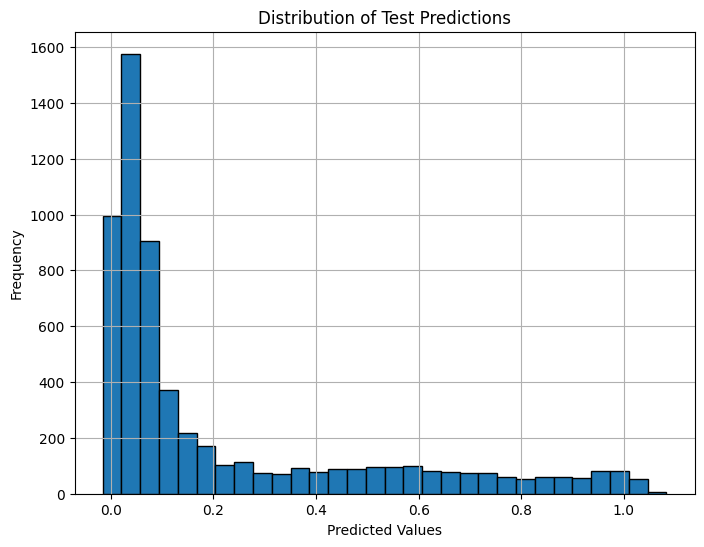

In [30]:

# 히스토그램을 그리기 위한 코드
plt.figure(figsize=(8, 6))
plt.hist(test_predictions, bins=30, edgecolor='k')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Distribution of Test Predictions')
plt.grid(True)
plt.show()


In [31]:
# 예측 확률
train_predictions = best_regression_model.predict(train_t_X)

# 초기 설정
best_threshold = 0.5
best_macro_f1 = 0
best_tp, best_fp, best_tn, best_fn = 0, 0, 0, 0

# 임계치 범위 설정
for threshold in np.arange(0.01, 1.01, 0.01):
    # 임계치 적용하여 예측 클래스 생성
    train_predictions_binary = (train_predictions > threshold).astype(int)

    # Macro F1 Score 계산
    macro_f1 = f1_score(train_y, train_predictions_binary, average='macro')

    # Confusion Matrix 계산
    tn, fp, fn, tp = confusion_matrix(train_y, train_predictions_binary).ravel()

    # 더 좋은 임계치를 찾았을 때 정보 저장
    if macro_f1 > best_macro_f1:
        best_threshold = threshold
        best_macro_f1 = macro_f1
        best_tp, best_fp, best_tn, best_fn = tp, fp, tn, fn

# 최적의 임계치와 결과 출력
print("Best Threshold:", best_threshold)
print("Best Macro F1 Score:", best_macro_f1)
print("True Positives:", best_tp)
print("False Positives:", best_fp)
print("True Negatives:", best_tn)
print("False Negatives:", best_fn)


Best Threshold: 0.39
Best Macro F1 Score: 0.8400543904606256
True Positives: 2283
False Positives: 787
True Negatives: 10284
False Negatives: 741


In [32]:
final_test_predictions = (test_predictions >= best_threshold).astype(int)

In [33]:
count_0 = np.sum(final_test_predictions == 0)
count_1 = np.sum(final_test_predictions == 1)

# 비율을 계산합니다.
ratio_0 = count_0 / len(final_test_predictions)
ratio_1 = count_1 / len(final_test_predictions)

# 결과 출력
print("Class 0 Ratio:", ratio_0)
print("Class 1 Ratio:", ratio_1)

Class 0 Ratio: 0.776858136070187
Class 1 Ratio: 0.22314186392981294


# 최종 제출 

In [34]:
submit = pd.read_csv('data/sample_submission.csv')
submit['Y_LABEL'] = final_test_predictions
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,1
4,TEST_0004,0


In [35]:
submit.to_csv('./final.csv', index=False)